# Sentiment Analysis - Labelled Financial News Data

This notebook focuses on conducting sentiment analysis using labeled financial news data. This involves analysing the sentiment expressed in financial news articles and categorising them as positive, negative, or neutral. The task includes understanding the characteristics of the dataset, exploring its content, preprocessing the text data, selecting appropriate feature representation techniques, training sentiment classifiers, and evaluating their performance. The objective is to develop accurate sentiment analysis models tailored to the financial domain.

The data is sourced from The Economic Times (Excluding the copyrighted Prime Articles)


In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rnrib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rnrib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First let's load the dataset and take a look at the first few rows.

In [215]:
# Load the data from the CSV file with utf-8 encoding
data = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

# duplicate the data
news = data.copy()

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


In [216]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date_published  400 non-null    object
 1   Headline        400 non-null    object
 2   Synopsis        399 non-null    object
 3   Full_text       400 non-null    object
 4   Final Status    400 non-null    object
dtypes: object(5)
memory usage: 15.8+ KB


There is a missing synopsis value in the dataset.

In [217]:
# print the row with the missing value for the 'synopsis' column
news[news['Synopsis'].isnull()]

,Date_published,Headline,Synopsis,Full_text,Final Status
56,2022-04-08,RBI keeps repo rate unchanged; reduces growth ...,NaN,ANIStory outlineThe benchmark repo rate stands...,Negative


Fill the missing value with an empty string.

In [218]:
# fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

Let's remane the columns to make it more readable.

In [219]:
# rename columns
news = news.rename(
    columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text',
             'Final Status': 'label'})
news.head()

,date,headline,synopsis,text,label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Check what kind of labels we have

In [220]:
# print unique labels and their counts
news.label.value_counts()

label
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64

There are 2 labels for positive values: 'Positive' and 'Positive '. 

In [221]:
# remove the spaces from the labels
news['label'] = news['label'].str.strip()

Now, there are only two correct labels: 'Positive' and 'Negative'. Let's analyse the final class distribution.

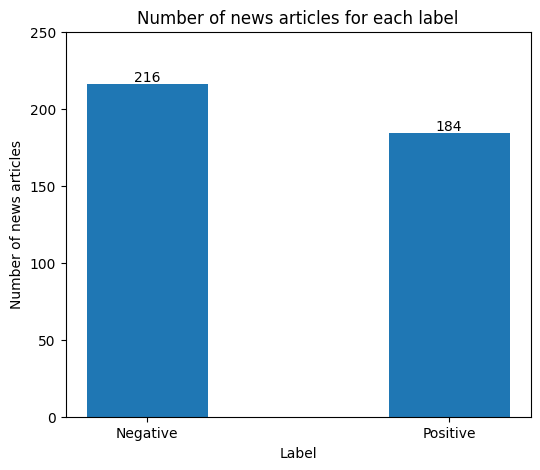

In [222]:
# plot the number of news articles for each label
fig = plt.figure(figsize=(6, 5))
plt.bar(news.label.unique(), news.label.value_counts(), width=0.4)
plt.title('Number of news articles for each label')
plt.xlabel('Label')
plt.ylabel('Number of news articles')
# add the number of news articles on top of each bar
for i, count in enumerate(news.label.value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')
# increase the margin at the top of each bar
plt.ylim(0, 250)
plt.show()

#### Let's clean the text columns:
    - Remove punctuation
    - Convert the text to lowercase
    - Tokenize the text
    - Remove stopwords
    - Apply PorterStemmer to the tokens

In [223]:
# list of text columns
text_columns = ['headline', 'synopsis', 'text']
# list to store the word tokens columns
word_tokens_columns = []

# stop words
stop_words = set(stopwords.words('english'))

# initialize the stemmer
stemmer = nltk.PorterStemmer()

# duplicate the data
news_cleaned = news.copy()

for col in text_columns:
    # covert each text column to a string
    news_cleaned[col] = news_cleaned[col].astype(str)
    # remove punctuation and non-alpha characters
    news_cleaned[col] = news_cleaned[col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    # create a word token column for each text column
    news_cleaned[col + '_word_tokens'] = news_cleaned[col].apply(word_tokenize)
    # add the column to the list
    word_tokens_columns.append(col + '_word_tokens')
    # remove stopwords from the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [token for token in tokens if token not in stop_words])
    # apply PorterStemmer to the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [stemmer.stem(token) for token in tokens])

# drop not needed columns
news_cleaned = news_cleaned[word_tokens_columns + ['label']]

news_cleaned

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


In [224]:
# import the required libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from gensim.models import Word2Vec

# duplicate the cleaned data
df = news_cleaned.copy()

df


,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


In [225]:
# transform the label column to binary
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positive' else 0)

df

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",0
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",1
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",1
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",0
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",1
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",0
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",0
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",0
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",1


Function to train and evaluate models

In [226]:
# Function to train and evaluate models
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return cm, precision, recall, f1


Let's define the models, token columns combinations, and feature representation methods.

In [227]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(max_iter=1000),
    'Multi-Layer Perceptron': MLPClassifier(max_iter=5000),
    'XGBoost': XGBClassifier()
}

# Define feature representation methods
feature_methods = {
    'Bag of Words': CountVectorizer(),
    'TF-IDF': TfidfVectorizer(),
    'Word2Vec': Word2Vec()
}


In [228]:
# Iterate through all models
results = []
for model_name, model in models.items():  # Iterate through all models
    for i in range(1, len(word_tokens_columns) + 1):  # Iterate through all token columns combinations
        for j in range(len(word_tokens_columns) - i + 1):
            # Select token columns
            selected_columns = word_tokens_columns[j:j + i]

            # Concatenate tokens within each list
            X = df[selected_columns].apply(lambda x: ' '.join([' '.join(item) for item in x]), axis=1)
            y = df['label']

            # Split the data into training and testing sets (70% training, 30% testing)
            # Ensuring that the class distribution is preserved in the training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            for method_name, method in feature_methods.items():
                if method_name == 'Word2Vec':
                    if model_name in ['Logistic Regression', 'Support Vector Machine', 'Multi-Layer Perceptron', 'XGBoost']:
                        # Train Word2Vec model
                        sentences = [text.split() for text in X_train]
                        w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

                        # Generate embeddings
                        X_train_embeddings = []
                        for text in X_train:
                            embedding = [w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                            if embedding:
                                X_train_embeddings.append(sum(embedding)/len(embedding))
                            else:
                                # Handle out-of-vocabulary words (e.g., by using a special token or skipping)
                                # Here, we're skipping the sentence if all words are out-of-vocabulary
                                X_train_embeddings.append([0] * w2v_model.vector_size)  # or any other placeholder value

                        # Similarly, generate embeddings for the test set
                        X_test_embeddings = []
                        for text in X_test:
                            embedding = [w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                            if embedding:
                                X_test_embeddings.append(sum(embedding) / len(embedding))
                            else:
                                # Handle out-of-vocabulary words
                                X_test_embeddings.append([0] * w2v_model.vector_size)

                        # Train and evaluate the model using the generated embeddings
                        cm, precision, recall, f1 = train_and_evaluate_model(X_train_embeddings, X_test_embeddings, y_train, y_test, model)
                    else:
                        # Skip Word2Vec for models that don't support embeddings
                        continue
                else:
                    # Vectorize text data
                    X_train_vec = method.fit_transform(X_train)
                    X_test_vec = method.transform(X_test)
                    cm, precision, recall, f1 = train_and_evaluate_model(X_train_vec, X_test_vec, y_train, y_test, model)
                result = {
                    'Model': model_name,
                    'Token Columns': ', '.join(selected_columns),
                    'Feature Representation': method_name,
                    'Confusion Matrix': cm,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                }
                # print(result)
                results.append(result)

# Visualize results
results_df = pd.DataFrame(results)

results_df


,Model,Token Columns,Feature Representation,Confusion Matrix,Precision,Recall,F1-score
0,Naive Bayes,headline_word_tokens,Bag of Words,"[[41, 14], [28, 37]]",0.725490,0.569231,0.637931
1,Naive Bayes,headline_word_tokens,TF-IDF,"[[35, 20], [26, 39]]",0.661017,0.600000,0.629032
2,Naive Bayes,synopsis_word_tokens,Bag of Words,"[[29, 26], [35, 30]]",0.535714,0.461538,0.495868
3,Naive Bayes,synopsis_word_tokens,TF-IDF,"[[25, 30], [25, 40]]",0.571429,0.615385,0.592593
4,Naive Bayes,text_word_tokens,Bag of Words,"[[42, 13], [35, 30]]",0.697674,0.461538,0.555556
...,...,...,...,...,...,...,...
103,XGBoost,"synopsis_word_tokens, text_word_tokens",TF-IDF,"[[34, 21], [19, 46]]",0.686567,0.707692,0.696970
104,XGBoost,"synopsis_word_tokens, text_word_tokens",Word2Vec,"[[26, 29], [25, 40]]",0.579710,0.615385,0.597015
105,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,"[[38, 17], [10, 55]]",0.763889,0.846154,0.802920
106,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",TF-IDF,"[[32, 23], [12, 53]]",0.697368,0.815385,0.751773


In [230]:
# get the best performing model
best_model = results_df[results_df['F1-score'] == results_df['F1-score'].max()]
best_model

,Model,Token Columns,Feature Representation,Confusion Matrix,Precision,Recall,F1-score
36,Decision Trees,"headline_word_tokens, synopsis_word_tokens",Bag of Words,"[[37, 18], [9, 56]]",0.756757,0.861538,0.805755


In [ ]:
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news['headline_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the top N words and their frequencies
top_words = word_freq.most_common(10)

# Extract words and frequencies
top_words, freq = zip(*top_words)

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news['headline_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Sort words by frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Extract sorted words and frequencies
words, freq = zip(*sorted_words)

# Plot the bar chart with all words sorted by frequency
plt.figure(figsize=(12, 6))
plt.bar(words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Words Frequency (Sorted by Frequency)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()
news_2 = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')
news_2.isna().sum()
news_2.dropna(inplace=True)

news_2 = news_2.drop(['Date_published', 'Headline', 'Synopsis'], axis=1)

In [ ]:
news_2['Scores'] = news_2['Full_text'].apply(lambda Full_text: vader_analyzer.polarity_scores(Full_text))
news_2['Compound'] = news_2['Scores'].apply(lambda d: d['compound'])

news_2

In [ ]:
import matplotlib.pyplot as plt

# Plot scores of each category
plt.figure(figsize=(10, 6))
for score_name in ['neg', 'neu', 'pos']:
    plt.plot(news_2['Scores'].apply(lambda x: x[score_name]), label=score_name)

plt.title('VADER Scores')
plt.xlabel('Record Index')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
# Plot compound score
plt.figure(figsize=(10, 6))
plt.plot(news_2['Compound'], label='Compound')

plt.title('VADER Compound Score')
plt.xlabel('Record Index')
plt.ylabel('Score')
plt.legend()
plt.show()